In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import win32com.client
import sqlite3

import sys
from enum import Enum
import time
import pythoncom

# FinanceDataReader 사용시 설정
# pip install -U finance-datareader
import FinanceDataReader as fdr
fdr.__version__

# matplotlib 그래프 한글지원
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()== 'Windows':
    path= 'c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties(fname=path).get_name()
    rc('font', family= font_name)
elif platform.system()=='Darwin':
    rc('font', family= 'AppleGothic')
else:
    print('포트를 지원하지 않습니다.')

# 증시의 과열(거품)을 확인할수있는 지표 : 신용잔고 오실레이터


## 신용잔고 오실레이터= log2(신용잔고 / (직전240일 신용잔고의 평균치))


http://freesis.kofia.or.kr/ 
금융투자협회 종합통계 -> 신용공여잔고추이 (신용거래융자, 신용거래대주, 예탁증권담보융자)


In [2]:
df_cd = pd.read_csv('./data/credit_day.csv', encoding='ANSI')
# df_kospi= pd.read_csv('./data/kospi_day.csv', encoding='ANSI')
# df_kosdaq= pd.read_csv('./data/kosdaq_day.csv', encoding='ANSI')
# df_kospi = fdr.DataReader('KS11', '2019') # KS11 (KOSPI 지수), 2015년~현재
# df_kosdaq = fdr.DataReader('KQ11', '2019')

In [3]:
df_kospi = fdr.DataReader('KS11', '2012') # KS11 (KOSPI 지수), 2015년~현재
df_kosdaq = fdr.DataReader('KQ11', '2012')

In [4]:
# 데이터 형변환
df_kosdaq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2029 entries, 2012-01-02 to 2020-03-27
Data columns (total 6 columns):
Close     2029 non-null float64
Open      2029 non-null float64
High      2029 non-null float64
Low       2029 non-null float64
Volume    2029 non-null float64
Change    2029 non-null float64
dtypes: float64(6)
memory usage: 111.0 KB


In [5]:
print(df_cd.shape)
print(df_kospi.shape)
print(df_kosdaq.shape)

(4552, 8)
(2028, 6)
(2029, 6)


In [6]:
df_cd.head(2)

,날짜,전체,유가증권,코스닥,전체1,유가증권1,코스닥1,전체2
0,2020-03-26,"6,436,078","3,087,901","3,348,177","6,318","3,643","2,675","15,326,477"
1,2020-03-25,"6,407,513","3,094,150","3,313,363","6,582","3,810","2,772","15,384,462"


In [7]:
df_cd.tail(2)

,날짜,전체,유가증권,코스닥,전체1,유가증권1,코스닥1,전체2
4550,2002-01-03,"219,018","219,018",0,38,38,0,0
4551,2002-01-02,"216,990","216,990",0,38,38,0,0


In [8]:
df_kospi.tail(2)

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-03-26,1686.24,1699.11,1735.75,1679.23,992470000.0,-0.0109
2020-03-27,1717.73,1756.07,1759.05,1668.21,1070000.0,0.0187


In [9]:
df_kospi.head(2)

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2012-01-02,1826.37,1831.69,1837.81,1814.55,323360000.0,0.0003
2012-01-03,1875.41,1846.56,1875.41,1846.56,443470000.0,0.0269


In [10]:
print(df_cd.isnull().any())
print(df_kospi.isnull().any())
print(df_kosdaq.isnull().any())

날짜       False
전체       False
유가증권     False
코스닥      False
전체1      False
유가증권1    False
코스닥1     False
전체2      False
dtype: bool
Close     False
Open      False
High      False
Low       False
Volume    False
Change    False
dtype: bool
Close     False
Open      False
High      False
Low       False
Volume    False
Change    False
dtype: bool


In [11]:
#
import locale
locale.setlocale( locale.LC_ALL, 'english_USA' )


'English_United States.1252'

In [12]:
for col in df_cd.columns[1:]:
    value_list=[]
    for v in df_cd[col].values:
        value_list.append(locale.atof(v))
    df_cd[col]= pd.Series(value_list) 

# for col in df_kospi.columns[1:-1]:
#     value_list=[]
#     for v in df_kospi[col].values:
#         value_list.append(locale.atof(v))
#     df_kospi[col]= pd.Series(value_list)     
    
# for col in df_kosdaq.columns[1:-1]:
#     value_list=[]
#     for v in df_kosdaq[col].values:
#         value_list.append(locale.atof(v))
#     df_kosdaq[col]= pd.Series(value_list) 
    
    

In [13]:
df_cd['날짜']= pd.to_datetime(df_cd['날짜'])
df_cd.set_index('날짜', inplace= True)
df_cd.head()

,전체,유가증권,코스닥,전체1,유가증권1,코스닥1,전체2
날짜,,,,,,,
2020-03-26,6436078.0,3087901.0,3348177.0,6318.0,3643.0,2675.0,15326477.0
2020-03-25,6407513.0,3094150.0,3313363.0,6582.0,3810.0,2772.0,15384462.0
2020-03-24,6447040.0,3109784.0,3337256.0,7122.0,4093.0,3030.0,15297205.0
2020-03-23,6767275.0,3261445.0,3505831.0,7626.0,4475.0,3151.0,15662857.0
2020-03-20,7524496.0,3611615.0,3912881.0,8917.0,5142.0,3775.0,16244888.0


In [14]:
print(df_cd.columns)
print(df_kospi.columns)
print(df_kosdaq.columns)


Index(['전체', '유가증권', '코스닥', '전체1', '유가증권1', '코스닥1', '전체2'], dtype='object')
Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change'], dtype='object')
Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change'], dtype='object')


In [15]:
# 날짜 내림차순 변경
df_kospi= df_kospi.sort_index(ascending= False)
df_kosdaq= df_kosdaq.sort_index(ascending= False)
df_kospi.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-03-27,1717.73,1756.07,1759.05,1668.21,1070000.0,0.0187
2020-03-26,1686.24,1699.11,1735.75,1679.23,992470000.0,-0.0109
2020-03-25,1704.76,1668.19,1707.64,1645.28,872810000.0,0.0589
2020-03-24,1609.97,1523.69,1609.97,1508.68,679290000.0,0.0860
2020-03-23,1482.46,1474.45,1516.75,1458.41,647530000.0,-0.0534


In [16]:
# merge
# 코스피지수, 코스닥지수, 코스피신용융자, 코스닥신용융자, 코스피신용대주, 코스닥신용대주, 예탁증권담보융자
df_all= None
#df_all= pd.merge(df_cd, df_kospi[['Close']], left_index=True, right_index=True, how='inner')
df_all= df_cd.join(df_kospi['Close'], how='inner')
df_all= df_all.rename(columns={'Close':'Kospi지수'})
df_all= df_all.join(df_kosdaq['Close'], how='inner')
df_all= df_all.rename(columns={'Close':'Kosdaq지수'})


In [17]:
df_all.head()

,전체,유가증권,코스닥,전체1,유가증권1,코스닥1,전체2,Kospi지수,Kosdaq지수
2020-03-26,6436078.0,3087901.0,3348177.0,6318.0,3643.0,2675.0,15326477.0,1686.24,516.61
2020-03-25,6407513.0,3094150.0,3313363.0,6582.0,3810.0,2772.0,15384462.0,1704.76,505.68
2020-03-24,6447040.0,3109784.0,3337256.0,7122.0,4093.0,3030.0,15297205.0,1609.97,480.40
2020-03-23,6767275.0,3261445.0,3505831.0,7626.0,4475.0,3151.0,15662857.0,1482.46,443.76
2020-03-20,7524496.0,3611615.0,3912881.0,8917.0,5142.0,3775.0,16244888.0,1566.15,467.75


In [18]:
print(df_all.shape)

(2027, 9)


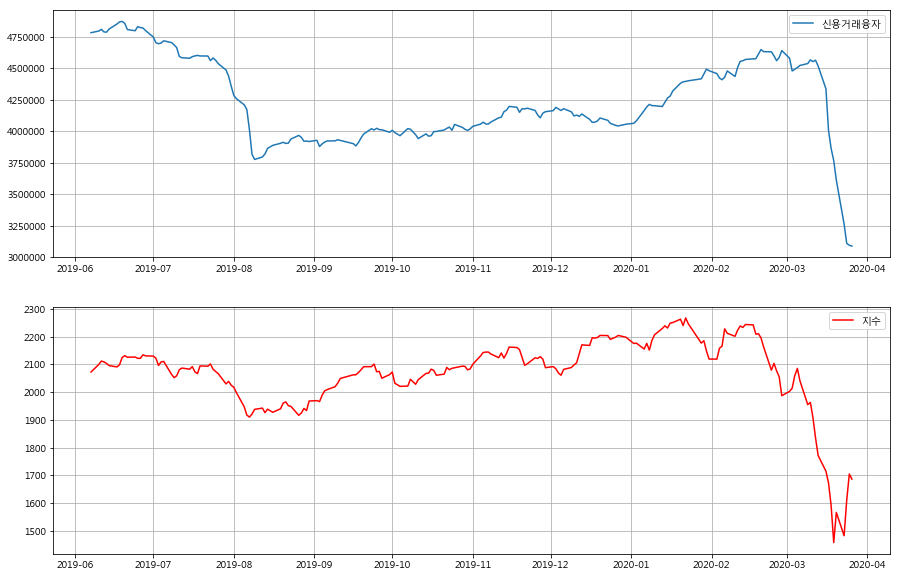

In [19]:
df_graph= df_all[:200].copy()
fig= plt.figure(figsize=(15,10))
ax1= fig.add_subplot(2,1,1)
ax2= fig.add_subplot(2,1,2)
ax1.plot(df_graph.index, df_graph['유가증권'], label='신용거래융자')
ax2.plot(df_graph.index, df_graph['Kospi지수'], label='지수', color='r')
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

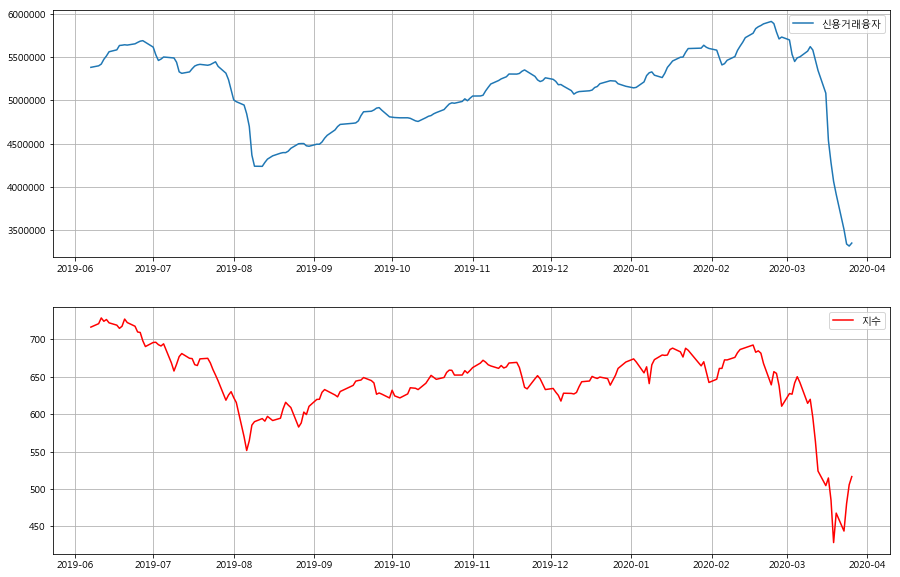

In [20]:
df_graph= df_all[:200].copy()
fig= plt.figure(figsize=(15,10))
ax1= fig.add_subplot(2,1,1)
ax2= fig.add_subplot(2,1,2)
ax1.plot(df_graph.index, df_graph['코스닥'], label='신용거래융자')
ax2.plot(df_graph.index, df_graph['Kosdaq지수'], label='지수', color='r')
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

In [21]:
df_cd.shape

(4552, 7)

In [22]:
df_cd= df_cd.sort_index(ascending= True)

In [23]:
df_cd.head()

,전체,유가증권,코스닥,전체1,유가증권1,코스닥1,전체2
날짜,,,,,,,
2002-01-02,216990.0,216990.0,0.0,38.0,38.0,0.0,0.0
2002-01-03,219018.0,219018.0,0.0,38.0,38.0,0.0,0.0
2002-01-04,217145.0,217145.0,0.0,38.0,38.0,0.0,0.0
2002-01-05,217105.0,217105.0,0.0,38.0,38.0,0.0,0.0
2002-01-07,212808.0,212808.0,0.0,43.0,43.0,0.0,0.0


In [24]:
#특정시점의 신용잔고의 연평균치에 대한 비율 -> 신용잔고의 증가속도 = 신용잔고/(직전240일 신용잔고의 평균치)
df_cd['유가증권비율']= df_cd['유가증권'] / (df_cd['유가증권'].rolling(window= 240).mean())
df_cd['코스닥비율']= df_cd['코스닥'] / (df_cd['코스닥'].rolling(window= 240).mean())
df_cd['유가증권비율로그']= np.log2(df_cd['유가증권비율'])
df_cd['코스닥비율로그']= np.log2(df_cd['코스닥비율'])

df_cd.dropna(inplace= True)

In [25]:
df_cd.tail()

,전체,유가증권,코스닥,전체1,유가증권1,코스닥1,전체2,유가증권비율,코스닥비율,유가증권비율로그,코스닥비율로그
날짜,,,,,,,,,,,
2020-03-20,7524496.0,3611615.0,3912881.0,8917.0,5142.0,3775.0,16244888.0,0.828709,0.744660,-0.271063,-0.425347
2020-03-23,6767275.0,3261445.0,3505831.0,7626.0,4475.0,3151.0,15662857.0,0.749405,0.668255,-0.416183,-0.581530
2020-03-24,6447040.0,3109784.0,3337256.0,7122.0,4093.0,3030.0,15297205.0,0.715656,0.637235,-0.482662,-0.650103
2020-03-25,6407513.0,3094150.0,3313363.0,6582.0,3810.0,2772.0,15384462.0,0.713158,0.633812,-0.487706,-0.657874
2020-03-26,6436078.0,3087901.0,3348177.0,6318.0,3643.0,2675.0,15326477.0,0.712831,0.641634,-0.488368,-0.640178


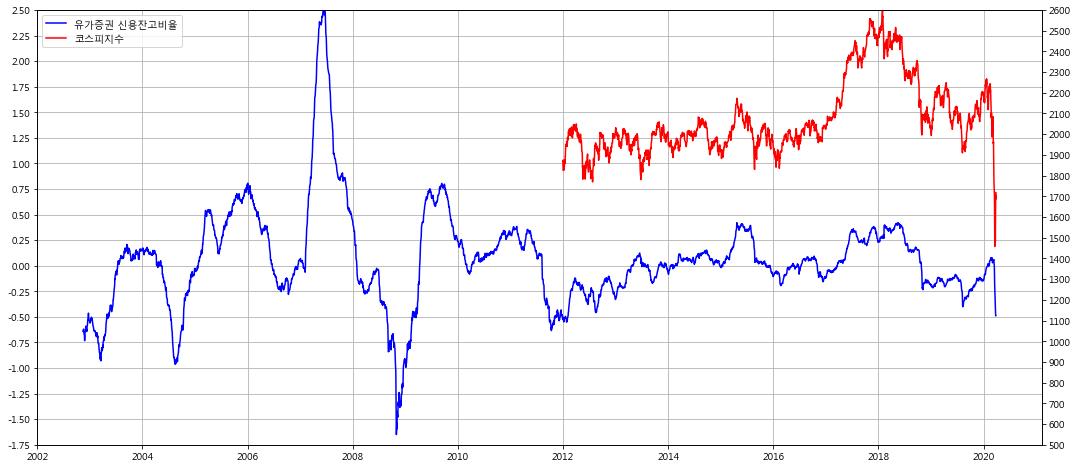

In [26]:
# http://blog.naver.com/PostView.nhn?blogId=onlyjeje&logNo=221168953266
# y축 2축 그래프 그리기

df_graph= df_cd[:].copy()
fig= plt.figure(figsize=(18,8))
ax1= fig.subplots()
ax2= ax1.twinx() # y축 2축 그래프 그리기
line1= ax1.plot(df_graph.index, df_graph['유가증권비율로그'], color='b', label='유가증권 신용잔고비율')
line2= ax2.plot(df_kospi.index, df_kospi['Close'], color='r', label='코스피지수')

# 축의 틱간격설정
ax1.set_yticks(np.arange(-3, 3, step=0.25))
ax2.set_yticks(np.arange(300, 3000, step=100))
#ax1.set_xticks(np.arange(-3, 3, step=0.25))

# 축의 범위설정
# ax1.set_ylabel('')
# ax2.set_ylabel('')
ax1.set_ylim(-1.75 , 2.5)
ax2.set_ylim(500, 2600)

# 레이블 표시하기
lines= line1+line2
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)



ax1.grid()
plt.show()



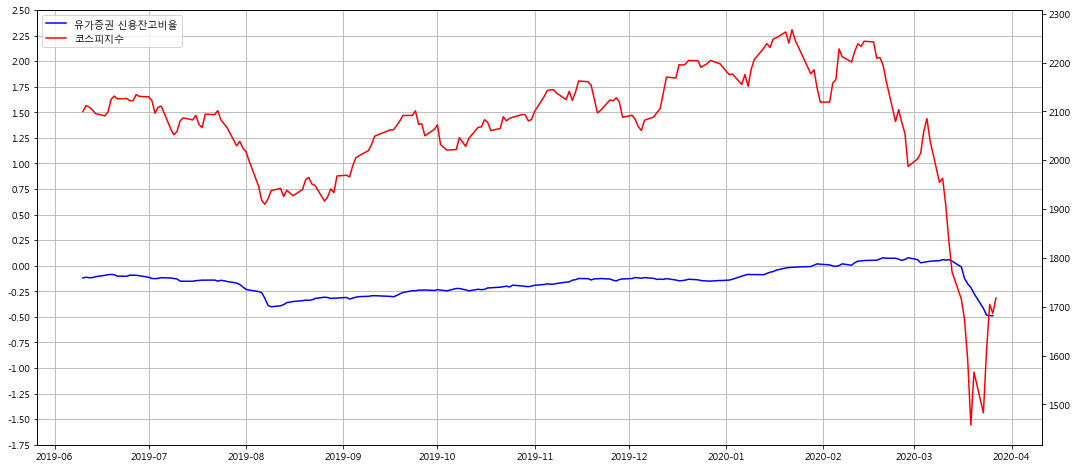

In [48]:
df_graph= df_cd[-200:].copy()
df_graph2= df_kospi[:200].copy()
fig= plt.figure(figsize=(18,8))
ax1= fig.subplots()
ax2= ax1.twinx() # y축 2축 그래프 그리기
line1= ax1.plot(df_graph.index, df_graph['유가증권비율로그'], color='b', label='유가증권 신용잔고비율')
line2= ax2.plot(df_graph2.index, df_graph2['Close'], color='r', label='코스피지수')

# 축의 틱간격설정
ax1.set_yticks(np.arange(-3, 3, step=0.25))
#ax2.set_yticks(np.arange(300, 3000, step=100))
#ax1.set_xticks(np.arange(-3, 3, step=0.25))

# 축의 범위설정
# ax1.set_ylabel('')
# ax2.set_ylabel('')
ax1.set_ylim(-1.75 , 2.5)
#ax2.set_ylim(500, 2600)

# 레이블 표시하기
lines= line1+line2
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)



ax1.grid()
plt.show()

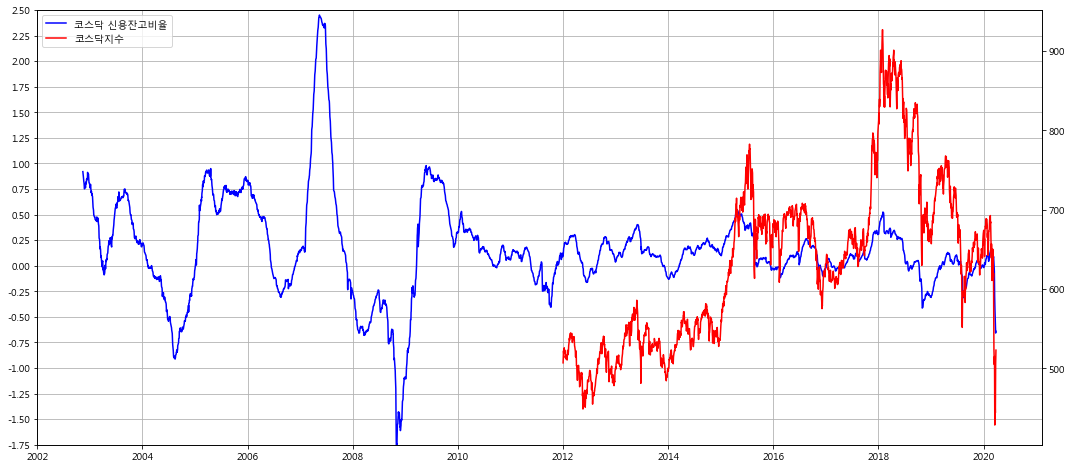

In [37]:
df_graph= df_cd[:].copy()
fig= plt.figure(figsize=(18,8))
ax1= fig.subplots()
ax2= ax1.twinx() # y축 2축 그래프 그리기
line1= ax1.plot(df_graph.index, df_graph['코스닥비율로그'], color='b', label='코스닥 신용잔고비율')
line2= ax2.plot(df_kosdaq.index, df_kosdaq['Close'], color='r', label='코스닥지수')

# 축의 틱간격설정
ax1.set_yticks(np.arange(-3, 3, step=0.25))
#ax2.set_yticks(np.arange(300, 3000, step=100))
#ax1.set_xticks(np.arange(-3, 3, step=0.25))

# 축의 범위설정
# ax1.set_ylabel('')
# ax2.set_ylabel('')
ax1.set_ylim(-1.75 , 2.5)
#ax2.set_ylim(500, 2300)

# 레이블 표시하기
lines= line1+line2
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)



ax1.grid()
plt.show()

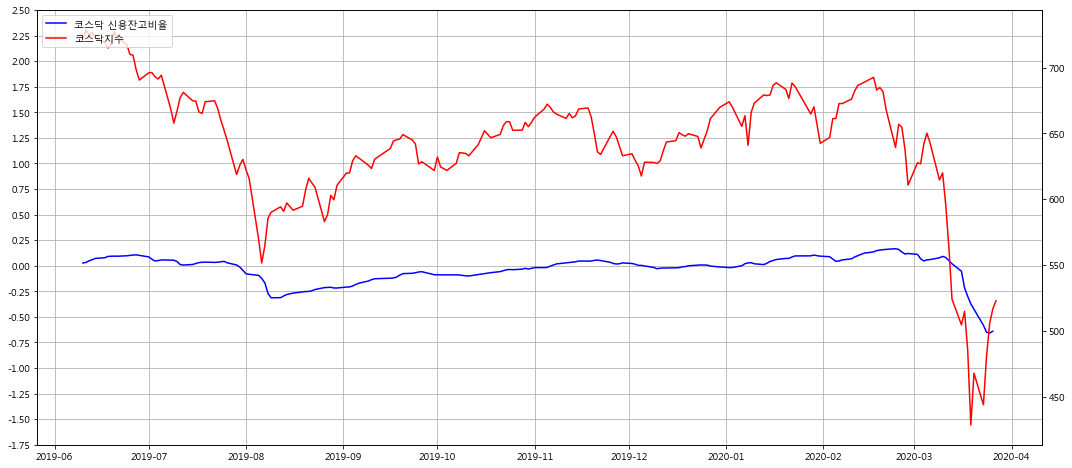

In [47]:
df_graph= df_cd[-200:].copy()
df_graph2= df_kosdaq[:200].copy()
fig= plt.figure(figsize=(18,8))
ax1= fig.subplots()
ax2= ax1.twinx() # y축 2축 그래프 그리기
line1= ax1.plot(df_graph.index, df_graph['코스닥비율로그'], color='b', label='코스닥 신용잔고비율')
line2= ax2.plot(df_graph2.index, df_graph2['Close'], color='r', label='코스닥지수')

# 축의 틱간격설정
ax1.set_yticks(np.arange(-3, 3, step=0.25))
#ax2.set_yticks(np.arange(300, 1000, step=50))
#ax1.set_xticks(np.arange(-3, 3, step=0.25))

# 축의 범위설정
# ax1.set_ylabel('')
# ax2.set_ylabel('')
ax1.set_ylim(-1.75 , 2.5)
#ax2.set_ylim(500, 2600)

# 레이블 표시하기
lines= line1+line2
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)



ax1.grid()
plt.show()

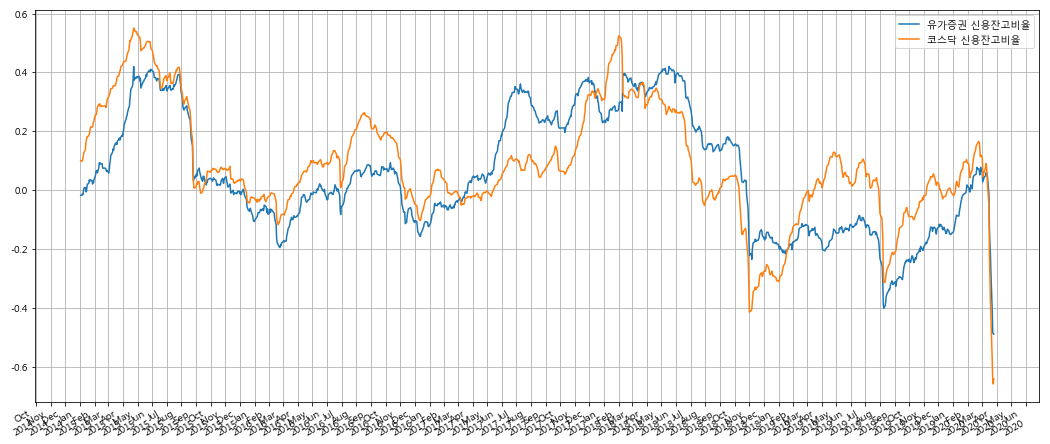

In [28]:
import matplotlib.dates as dates

df_graph= df_cd['2015':].copy()

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(df_graph.index, df_graph['유가증권비율로그'], label='유가증권 신용잔고비율')
ax.plot(df_graph.index, df_graph['코스닥비율로그'], label='코스닥 신용잔고비율')

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
fig.autofmt_xdate() # Auto fixes the overlap!

plt.legend()
plt.grid()
plt.show()

# 코스닥 - 코스피 > 0 위험권, 개미->코스닥 (골든크로스, 데드크로스의 관점)

# ADR지표 (Advance Decline Ratio)

ADR = (20거래일 상승종목수 누계 / 하락종목수 누계) * 100

20거래일 동안 상승종목 누계를 하락종목 누계로 나눈 백분율로 표시하며, 
증권시장 내의 매수세력과 매도세력의 크기를 가늠하는 지표로 쓰이고 있습니다. 
ADR이 100%인 경우는 상승종목수와 하락종목수가 균형을 이루고 있다는 것을 나타내며 
120% 이상이면 과열권, 75% 이하면 바닥권으로 판단합니다.

http://www.adrinfo.kr/chart

# 개별종목의 신용잔고비율, 공매도 확인하기

신용융자 잔고는 증권사에서 돈을 빌려 주식을 매수한 금액입니다. 
주로 개인투자자가 이용하는 만큼, 이들의 투자심리를 간접적으로 확인할 수 있다. 
신용융자 잔고가 늘면 그만큼 향후 주가상승에 대한 기대가 높다고 볼 수도 있지만, 
반대로 주가하락시 빌린 자금에 대한 부담으로 하락 폭이 커질 우려도 있다. 

In [2]:

instCpCybos= win32com.client.Dispatch("CpUtil.CpCybos")

# 연결 여부 체크
bConnect = instCpCybos.IsConnect
if (bConnect == 1):
    print("연결되었음.")
else:
    print("연결되지않음.")   



연결되었음.


In [11]:
# [융자 주식 및 대금의 변동] CpSysDib.CpSvr7151
#신용공여 업무상 발생하는 융자 주식 및 대금의 변동 사항을 종목별, 업종별로 요청하고 수신합니다.
inst= win32com.client.Dispatch('CpSysDib.CpSvr7151')

종목코드= 'A084990' #A045520 크린앤사이언스, A044340 위닉스, A263750 펄어비스, A084990 바이로메드
result=[]

inst.SetInputValue(0, 종목코드) # 0 종목코드
inst.SetInputValue(1, ord('y')) # 융자/대주 , y/d
inst.SetInputValue(2, ord('1')) # 결제기준/매매기준, 1/2

inst.BlockRequest()

#현재가 통신 및 통신 에러 처리
rqStatus = inst.GetDibStatus()
#print('통신상태', rqStatus)
if rqStatus != 0:
    print('통신실패') 

numData= inst.GetHeaderValue(0) # 3 수신개수
#print(numData)
#일자, 종가, 대비, 등락율, 거래량, 신규, 상환, 잔고, 금액, 잔고대비, 공여율, 잔고율
for i in range(numData):
    날짜= str(inst.GetDataValue(0,i))
    종가= int(inst.GetDataValue(1,i))
    신규= float(inst.GetDataValue(5,i))
    상환= float(inst.GetDataValue(6,i))
    잔고= float(inst.GetDataValue(7,i))    
    금액= float(inst.GetDataValue(8,i))
    #잔고대비= float(inst.GetDataValue(9,i))
    공여율= float(inst.GetDataValue(10,i)) # 총거래 대비 신용거래의 비율
    잔고율= float(inst.GetDataValue(11,i)) # 전체상장주식수중 신용거래로 매수한 비율

    result.append([날짜,종가,신규,상환,잔고,금액,공여율,잔고율])
    
print(inst.Continue)
    
df_local= pd.DataFrame(result, columns=['날짜','종가','신규','상환','잔고','금액','공여율','잔고율'])   

print(종목코드,'조회완료',df_local.shape)




0
A084990 조회완료 (150, 8)


In [12]:
df_local.drop(df_local[df_local['종가']==0].index, inplace=True)

df_local['날짜']= pd.to_datetime(df_local['날짜'])
df_local.set_index('날짜', inplace= True)

In [13]:
df_local.head(10)

,종가,신규,상환,잔고,금액,공여율,잔고율
날짜,,,,,,,
2019-05-22,214500,11794.0,22386.0,486889.0,97943.0,9.0,3.04
2019-05-21,214200,10708.0,11876.0,497481.0,100218.0,10.0,3.10
2019-05-20,211900,24876.0,18201.0,498649.0,100920.0,18.0,3.12
2019-05-17,222500,17544.0,23579.0,491990.0,99623.0,10.0,3.07
2019-05-16,224300,6980.0,10421.0,498025.0,100895.0,7.0,3.12
2019-05-15,239400,16318.0,13285.0,501466.0,101704.0,15.0,3.13
2019-05-14,225500,8797.0,18586.0,498433.0,101281.0,7.0,3.11
2019-05-13,223700,17333.0,19255.0,508222.0,103334.0,12.0,3.17
2019-05-10,225500,19530.0,24866.0,510175.0,104448.0,10.0,3.18


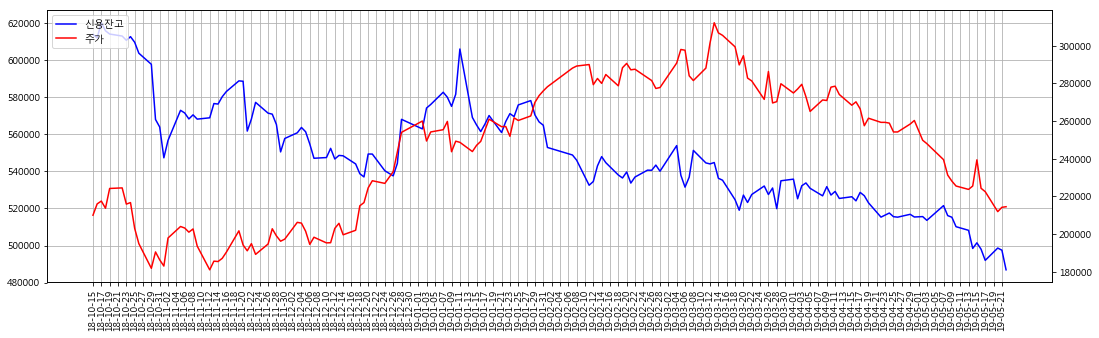

In [14]:

df_graph= df_local[:].copy()
fig= plt.figure(figsize=(18,5))

# x축 틱설정
xticks= pd.date_range(start=df_graph.index.min(), end=df_graph.index.max(), freq='2D')
xticks_name= [d for d in xticks.strftime('%y-%m-%d')]

ax1= fig.subplots()
line1= ax1.plot(df_graph.index, df_graph['잔고'], color='b', label='신용잔고')
plt.xticks(xticks, xticks_name, rotation= 90)

ax2= ax1.twinx() # y축 2축 그래프 그리기
line2= ax2.plot(df_graph.index, df_graph['종가'], color='r', label='주가')
plt.xticks(xticks, xticks_name, rotation= 90)


#레이블 표시하기
lines= line1+line2
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)
ax1.grid()
plt.show()



In [15]:
# 일자별 공매도 추이 CpSysDib.CpSvr7238
# 종목별 공매도 추이를 요청하고 수신한다.

# 일자별 대차거래 CpSysDib.CpSvr7240
#주식종목에 대한 일자별 대차거래를 요청하고 수신합니다.



inst= win32com.client.Dispatch('CpSysDib.CpSvr7240')

종목코드= 'A084990' #A045520 크린앤사이언스, A044340 위닉스, A263750 펄어비스, A084990 바이로메드
result=[]

inst.SetInputValue(0, 종목코드) # 0 종목코드

for i in range(3): # 연속조회
    
    inst.BlockRequest()

    #현재가 통신 및 통신 에러 처리
    rqStatus = inst.GetDibStatus()
    #print('통신상태', rqStatus)
    if rqStatus != 0:
        print('통신실패') 

    numData= inst.GetHeaderValue(0) # 3 수신개수

    for i in range(numData):
        날짜= str(inst.GetDataValue(0,i))
        종가= int(inst.GetDataValue(1,i))
    #     전일대비= float(inst.GetDataValue(2,i))
    #     전일대비율= float(inst.GetDataValue(3,i))
    #     거래량= float(inst.GetDataValue(4,i))    
        공매도량= float(inst.GetDataValue(5,i))
        대차= float(inst.GetDataValue(6,i))
        상환= float(inst.GetDataValue(7,i)) 
        대차잔고증감= float(inst.GetDataValue(8,i)) 
        대차잔고주수= float(inst.GetDataValue(9,i)) 
        대차잔고금액= float(inst.GetDataValue(10,i)) 

        result.append([날짜,종가,공매도량,대차,상환,대차잔고증감,대차잔고주수,대차잔고금액])

    if inst.Continue != True:
        break
        
    print('연속조회')
    
df_local= pd.DataFrame(result, columns=['날짜','종가','공매도량','대차','상환','대차잔고증감','대차잔고주수','대차잔고금액'])   

print(종목코드,'조회완료',df_local.shape)






연속조회
연속조회
연속조회
A084990 조회완료 (150, 8)


In [16]:
df_local.drop(df_local[df_local['종가']==0].index, inplace=True)

df_local['날짜']= pd.to_datetime(df_local['날짜'])
df_local.set_index('날짜', inplace= True)

In [17]:
df_local.head(10)

,종가,공매도량,대차,상환,대차잔고증감,대차잔고주수,대차잔고금액
날짜,,,,,,,
2019-05-22,214500,13657.0,20777.0,37107.0,-16330.0,2634836.0,565172.0
2019-05-21,214200,19586.0,1666.0,9642.0,-7976.0,2651166.0,567879.0
2019-05-20,211900,16300.0,283724.0,19199.0,264525.0,2659142.0,563472.0
2019-05-17,222500,16225.0,27354.0,61012.0,-33658.0,2394617.0,532802.0
2019-05-16,224300,8524.0,22986.0,48275.0,-25289.0,2428275.0,544662.0
2019-05-15,239400,14226.0,45497.0,24718.0,20779.0,2451834.0,586969.0
2019-05-14,225500,25490.0,33090.0,25580.0,7510.0,2431055.0,548202.0
2019-05-13,223700,11133.0,75170.0,4498.0,70672.0,2387242.0,534026.0
2019-05-10,225500,18053.0,22620.0,21216.0,1404.0,2315349.0,522111.0


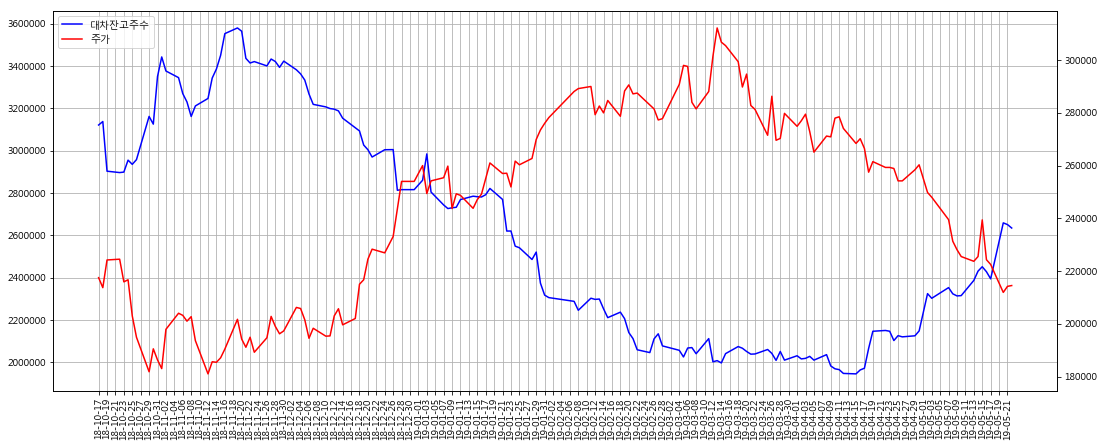

In [18]:
df_graph= df_local[:].copy()
fig= plt.figure(figsize=(18,7))

# x축 틱설정
xticks= pd.date_range(start=df_graph.index.min(), end=df_graph.index.max(), freq='2D')
xticks_name= [d for d in xticks.strftime('%y-%m-%d')]

ax1= fig.subplots()
#line1= ax1.plot(df_graph.index, df_graph['공매도량'], color='b', label='공매도량')
line1= ax1.plot(df_graph.index, df_graph['대차잔고주수'], color='b', label='대차잔고주수')
plt.xticks(xticks, xticks_name, rotation= 90)

ax2= ax1.twinx() # y축 2축 그래프 그리기
line2= ax2.plot(df_graph.index, df_graph['종가'], color='r', label='주가')
plt.xticks(xticks, xticks_name, rotation= 90)


#레이블 표시하기
lines= line1+line2
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)
ax1.grid()
plt.show()

# 장단기금리차 (국채 10년물 - 3년물)
# https://fred.stlouisfed.org/series/T10Y2Y
# http://yellow.kr/financeView.jsp?s=T10Y2Y
# http://yellow.kr/blog/?p=2459  (미국채 설명)
# http://ecos.bok.or.kr/  (한국국채) 한국은행경제통계시스템->금리->시장금리


